In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import scipy.signal as signal
import neurokit2 as nk

base_path = r"D:\Extra datasets\brno-university-of-technology-ecg-quality-database-but-qdb-1.0.0\100001\100001"
ecg_path = base_path + r"_ECG"


In [2]:
def ann_reader(path):
    # Load annotations
    raw = pd.read_csv(path, sep=',', engine="python", header=None)
    # Optionally set column names if you know them, e.g.:
    # raw.columns = ["start1", "end1", "val1", ..., "start4", "end4", "val4"]

    for c in raw.columns:
        raw[c] = pd.to_numeric(raw[c], errors="coerce")
        if pd.api.types.is_float_dtype(raw[c]):
            if (raw[c].dropna() % 1 == 0).all():
                raw[c] = raw[c].astype('Int64')

    starts = raw.iloc[:, 9].dropna()   # 10.,11.,12. kolonne = consensus (0-baseret: 9,10,11)
    ends   = raw.iloc[:,10].dropna()
    labels   = raw.iloc[:,11].dropna()

    # Convert the loaded data
    segments = []
    for start, end, label in zip(starts, ends, labels):
        if pd.isna(start) or pd.isna(end) or pd.isna(label):
            continue
        # For each segment, fill a list with the value for each index in the range [start, end]
        segments.extend([int(label)] * (int(end) - int(start) + 1))

    # # Validation of loaded annotations

    # print(labels[0])
    # print(starts[0])
    # print(ends[0])

    # print(len(segments))  # Total length of the segments list
    # print(segments[100:])  # Print the first 100 values to verify

    return segments, starts, ends, labels

In [45]:
ann, starts, ends, labels = ann_reader(base_path + r"_ANN.csv")
print(len(ann))
print(len(starts))
print(len(ends))
print(len(labels))
print(len(segments))

87087000
763
763
763
762


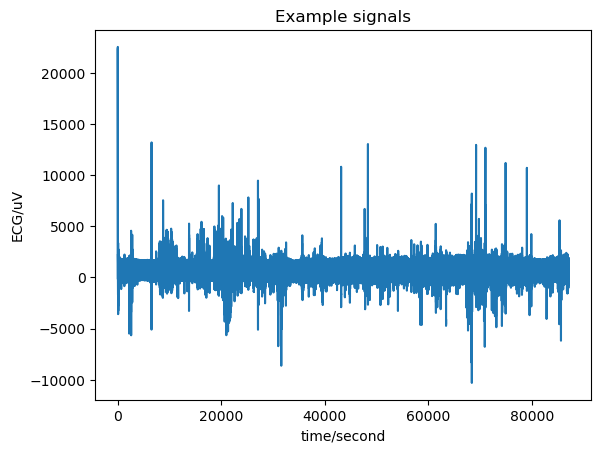

In [4]:
# load a record using the 'rdrecord' function
record = wfdb.rdrecord(ecg_path)

# plot the record to screen
wfdb.plot_wfdb(record=record, title='Example signals')

In [5]:
# Validation of loaded record, compare with raw load online: https://physionet.org/lightwave/?db=butqdb/1.0.0
# print(record.p_signal[:20] if record.p_signal is not None else record.d_signal[:20])
fs = record.fs  # Sampling frequency
print(f"Sampling frequency: {fs} Hz")

Sampling frequency: 1000 Hz


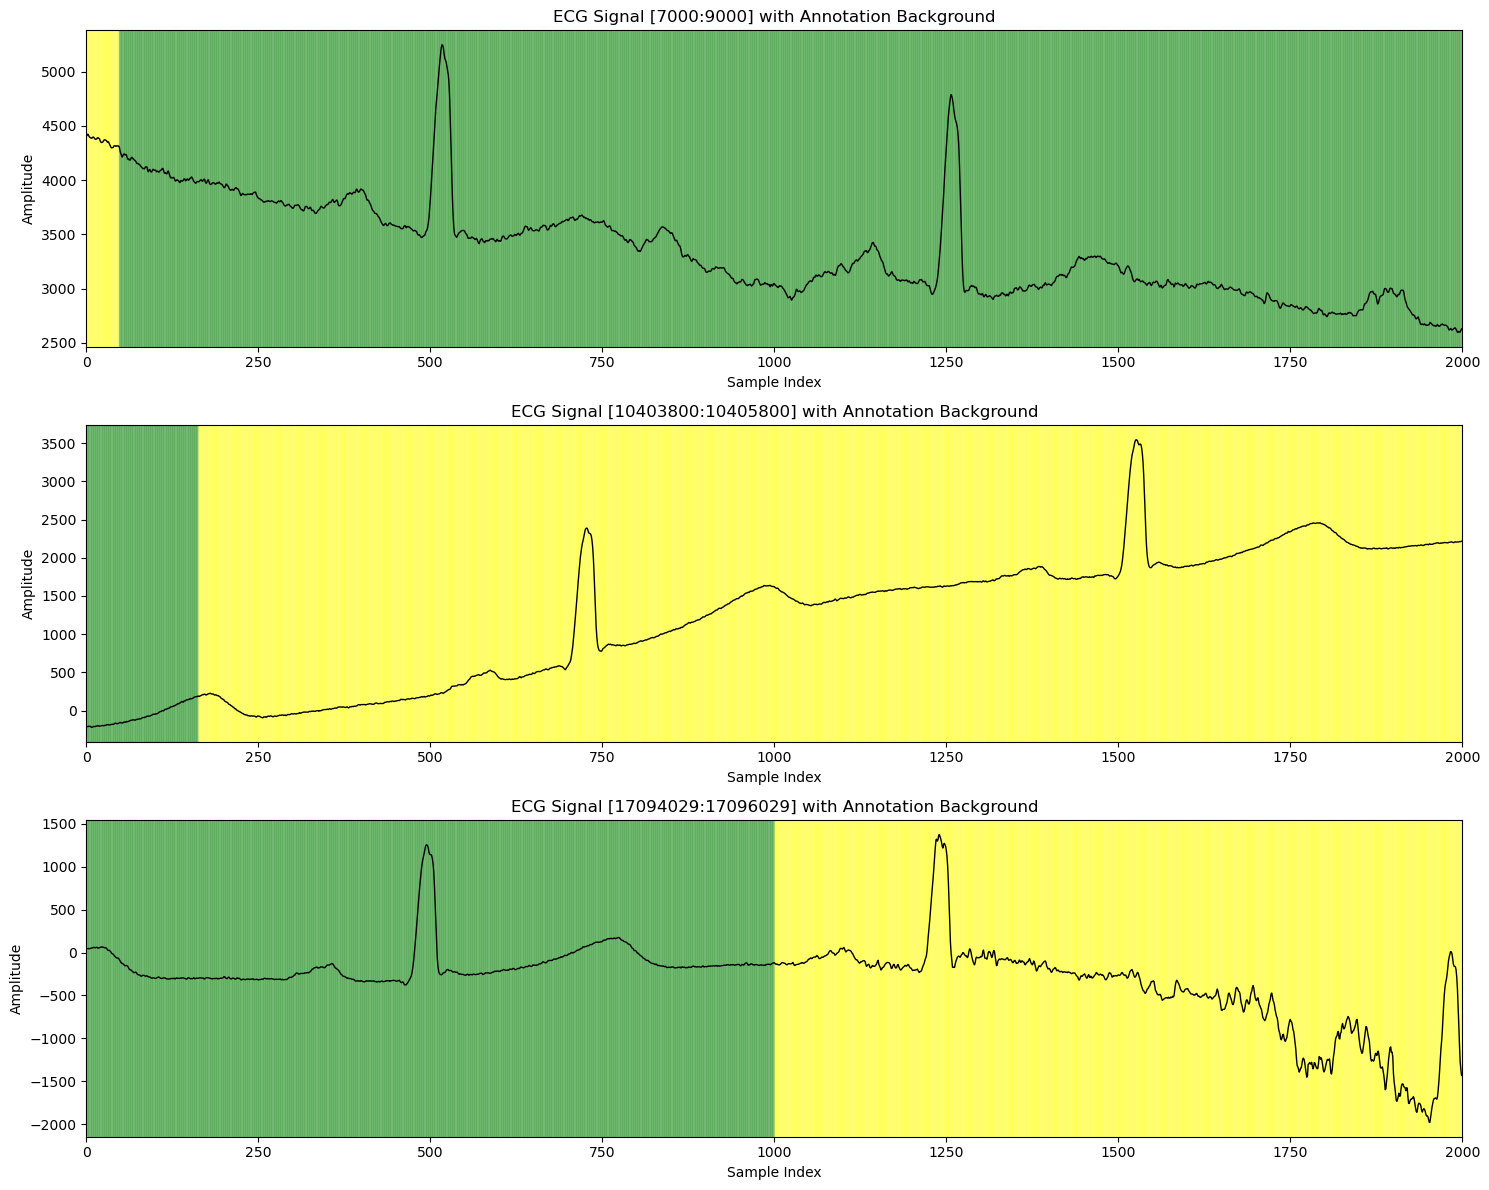

In [6]:
# Define windows to visualize (start, end) tuples
windows = [
    (7000, 9000),  # Example: 2000 samples, adjust as needed
    (10403800, 10405800),
    (17094029, 17096029)
]
colors = {
    1: 'green',   # Good quality
    2: 'yellow',  # Medium quality
    3: 'red'      # Poor quality
}

fig, axes = plt.subplots(len(windows), 1, figsize=(15, 4 * len(windows)), sharex=False)

for idx, (start, end) in enumerate(windows):
    sig = record.p_signal[start:end, 0] if record.p_signal is not None else record.d_signal[start:end, 0]
    ann_window = ann[start:end]
    ax = axes[idx] if len(windows) > 1 else axes

    ax.plot(sig, color='black', linewidth=1)
    for i in range(len(ann_window)):
        ax.axvspan(i, i+1, color=colors.get(ann_window[i], 'gray'), alpha=0.2)
    ax.set_title(f"ECG Signal [{start}:{end}] with Annotation Background")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Amplitude")
    ax.set_xlim(0, len(sig))

plt.tight_layout()
plt.show()


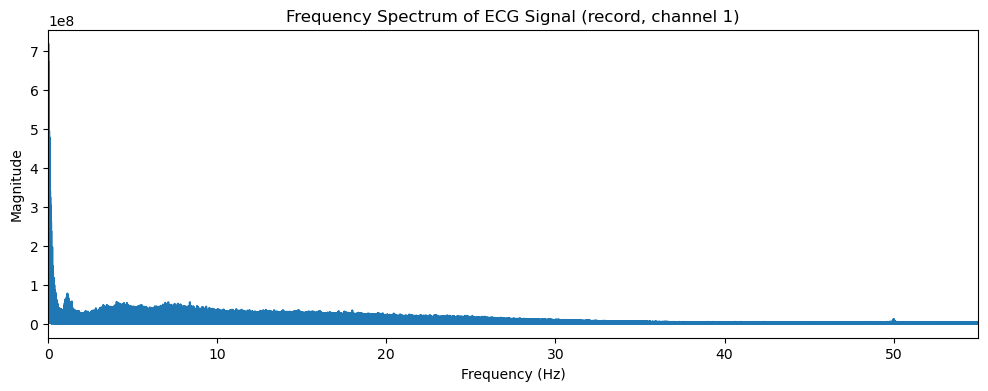

In [7]:
import matplotlib.pyplot as plt

# Frequency analysis using FFT on the signal in 'record'
raw_signal = record.p_signal if record.p_signal is not None else record.d_signal.astype(float)
fs = float(record.fs)
N = raw_signal.shape[0]

# If multi-channel, select first channel for example
sig1 = raw_signal[:, 0] if raw_signal.ndim > 1 else raw_signal

fft_raw = np.fft.fft(sig1)
freqs = np.fft.fftfreq(N, d=1/fs)
plt.figure(figsize=(12, 4))
plt.plot(freqs[:N//2], np.abs(fft_raw)[:N//2])
plt.title("Frequency Spectrum of ECG Signal (record, channel 1)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, 55)
plt.show()

In [8]:
b, a = signal.butter(5, 0.5, btype='highpass', fs=fs)
filtered_signal = signal.filtfilt(b, a, raw_signal[:, 0] if raw_signal.ndim > 1 else raw_signal)

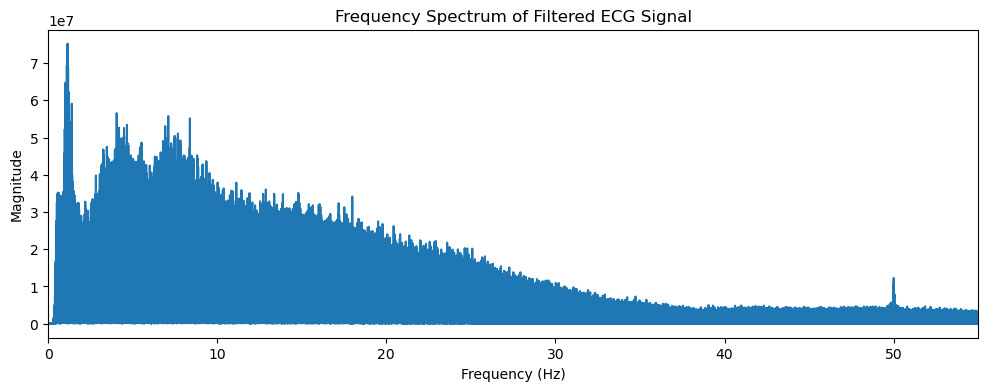

In [9]:
fft_filtered = np.fft.fft(filtered_signal)
freqs_filtered = np.fft.fftfreq(len(filtered_signal), d=1/fs)

plt.figure(figsize=(12, 4))
plt.plot(freqs_filtered[:len(filtered_signal)//2], np.abs(fft_filtered)[:len(filtered_signal)//2])
plt.title("Frequency Spectrum of Filtered ECG Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, 55)
plt.show()

In [46]:


# Setup segments for futhere analysis
segments = []
for i in range(len(starts)):
    if pd.isna(starts[i]) or pd.isna(ends[i]) or pd.isna(ann[i]):
        continue
    segments.append((starts[i], ends[i]))
    # print(i)

print(f"Total segments: {len(segments)}")

# # Process each segment with ecg_quality
# quality_results = []
# for seg_start, seg_end, seg_val in segments:
#     # # Limit segment length for practical computation (e.g., max 10000 samples)
#     # if seg_end - seg_start > 10000:
#     #     seg_end = seg_start + 10000
#     segment_signal = raw_signal[seg_start:seg_end, 0] if raw_signal.ndim > 1 else raw_signal[seg_start:seg_end]
#     quality = nk.ecg_quality(segment_signal, sampling_rate=fs, method='averageQRS')
#     quality_results.append({'start': seg_start, 'end': seg_end, 'ann_val': seg_val, 'quality': quality})

Total segments: 763


In [11]:
# print(segments[0][1])



# for seg in segments:
#     nk.ecg_quality(raw_signal[seg[0]:seg[1], 0] if raw_signal.ndim > 1 else raw_signal[seg[0]:seg[1]], sampling_rate=fs, method='averageQRS')

In [12]:
import neurokit2 as nk
import numpy as np
import pandas as pd

def sqi_averageQRS(ecg, fs):
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs, method="neurokit")
    _, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    q = nk.ecg_quality(ecg_clean, rpeaks=info["ECG_R_Peaks"], sampling_rate=fs, method="averageQRS")
    return q  # pr. beat; aggreger i vinduer

def sqi_zhao2018(ecg, fs):
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs)
    _, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    labels = nk.ecg_quality(ecg_clean, rpeaks=info["ECG_R_Peaks"], sampling_rate=fs, method="zhao2018")
    # map {"Unacceptable":0, "Barely acceptable":1, "Excellent":2} eller til 0–1
    return labels

def sqi_hrv_rmssd(ecg, fs):
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs)
    _, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    rpeaks = info["ECG_R_Peaks"]
    rr = np.diff(rpeaks) / fs  # sek
    # evt. korriger "uregelmæssige" RR her (tidsvar. tærskler) som i artiklen
    rmssd = np.sqrt(np.mean(np.diff(rr)**2))
    # implementér artiklens tærskel-logik: tælle "abnorme" RR og returnér SQI i [0,1]
    # ... din logik her ...
    return sqi_value

def sqi_morph_corr(ecg, fs, qrs_len=0.12):
    ecg_clean = nk.ecg_clean(ecg, sampling_rate=fs)
    _, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    epochs = nk.ecg_segment(ecg_clean, rpeaks=info["ECG_R_Peaks"], sampling_rate=fs)
    waves = [np.asarray(epochs[k]["Signal"].values) for k in epochs]  # eller brug epochs_to_df
    # z-score hvert QRS, beregn korrelation mellem konsekutive, tag gennemsnit
    corr = []
    for i in range(len(waves)-1):
        a = (waves[i] - np.mean(waves[i])) / (np.std(waves[i]) + 1e-8)
        b = (waves[i+1] - np.mean(waves[i+1])) / (np.std(waves[i+1]) + 1e-8)
        corr.append(np.corrcoef(a, b)[0,1])
    return float(np.nanmean(corr))

def classify_sqi(sqi_mean):
    if sqi_mean < 0.33:
        return "Unacceptable"
    elif sqi_mean < 0.66:
        return "Barely acceptable"
    else:
        return "Excellent"


In [13]:
# res = sqi_averageQRS(raw_signal[0:10000000],1000)

In [14]:
# print(max(res))
# print(min(res))
# print(len(res))
# print(res[7000:7100])

In [15]:
res = sqi_averageQRS(raw_signal,1000)

In [16]:
result_mean = []
result_median = []

for seg in segments:
    # print(seg[0]-1, seg[1]-1)
    
    res_mean = np.mean(res[seg[0]-1:seg[1]-1])
    result_mean.append(res_mean)
    res_median = np.median(res[seg[0]-1:seg[1]-1])
    result_median.append(res_median)

# Classify based on mean SQI
classified_mean = [classify_sqi(sqi) for sqi in result_mean]
# Classify based on median SQI
classified_median = [classify_sqi(sqi) for sqi in result_median]



In [17]:
# print(len(labels))
# print(len(labels_pred))

In [18]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# # Prepare DataFrame for evaluation
# df = pd.DataFrame({
#     "label_true": [classify_sqi(val) for val in labels.dropna()],
#     "sqi_mean": result_mean[:len(labels.dropna())]
# })
# df["label_pred"] = df["sqi_mean"].apply(classify_sqi)

# cm = confusion_matrix(df["label_true"], df["label_pred"], labels=["Unacceptable", "Barely acceptable", "Excellent"])
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Unacceptable", "Barely acceptable", "Excellent"])
# disp.plot(cmap="Blues")
# plt.show()

# print(classification_report(df["label_true"], df["label_pred"]))


In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# --- 1) Kør én gang på HELE signalet ---
ecg_clean = nk.ecg_clean(raw_signal, sampling_rate=fs, method="neurokit")

In [20]:
_, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)

In [ ]:
rpeaks_idx = info["ECG_R_Peaks"]            # beat-indeks i SAMPLES

In [ ]:
# Average SQI
q_beats = nk.ecg_quality(ecg_clean, rpeaks=rpeaks_idx, sampling_rate=fs, method="averageQRS")
# q_beats har samme længde som rpeaks_idx

In [69]:
# SQI Fussy
q_beats_fussy = nk.ecg_quality(ecg_clean[segments[2][0]:segments[2][1]], rpeaks=rpeaks_idx, sampling_rate=fs, method="zhao2018")

In [85]:
counter = 0
q_beats_test1 = []
q_beats_fussy_test1 = []
for seg in segments:
    if seg[1] - seg[0] < 4000:
        q_beats1 = 0
        q_beats_test1.append(np.mean(q_beats1))
        q_beats_fussy1 = "Unacceptable"
        q_beats_fussy_test1.append(q_beats_fussy1)
        counter += 1
        continue
    q_beats1 = nk.ecg_quality(ecg_clean[seg[0]:seg[1], 0] if ecg_clean.ndim > 1 else ecg_clean[seg[0]:seg[1]], sampling_rate=fs, method='averageQRS')
    # print(q_beats1)
    # print(np.mean(q_beats1))
    q_beats_test1.append(np.mean(q_beats1))
    q_beats_fussy1 = nk.ecg_quality(ecg_clean[seg[0]:seg[1], 0] if ecg_clean.ndim > 1 else ecg_clean[seg[0]:seg[1]], sampling_rate=fs, method='zhao2018')
    q_beats_fussy_test1.append(q_beats_fussy1)

print("How many segments skipped due to length < 4000:", counter)



How many segments skipped due to length < 4000: 179


In [66]:
print(segments[0])

(1, 7047)


In [70]:
# Check and validation of parameters
print(len(segments))
print(len(labels))
print(rpeaks_idx.shape)
print(rpeaks_idx[0])

print(segments)
print(q_beats.shape)
print(q_beats_fussy)

763
763
(117206,)
310
[(1, 7047), (7048, 17209), (17210, 28694), (28695, 32653), (32654, 112474), (112475, 174872), (174873, 192330), (192331, 1163574), (1163575, 1165034), (1165035, 2197584), (2197585, 2322254), (2322255, 2331166), (2331167, 2333950), (2333951, 2353306), (2353307, 2582882), (2582883, 2778473), (2778474, 2789032), (2789033, 6493775), (6493776, 6494615), (6494616, 6504788), (6504789, 6528944), (6528945, 8103188), (8103189, 8183677), (8183678, 8207266), (8207267, 8269766), (8269767, 8285982), (8285983, 8679655), (8679656, 8736748), (8736749, 8746245), (8746246, 9369503), (9369504, 9796000), (9796001, 10032664), (10032665, 10033565), (10033566, 10296954), (10296955, 10335664), (10335665, 10403962), (10403963, 10542981), (10542982, 11468257), (11468258, 11477831), (11477832, 11644085), (11644086, 11656399), (11656400, 12844392), (12844393, 12854198), (12854199, 13742716), (13742717, 13760626), (13760627, 15836454), (15836455, 15869858), (15869859, 15993438), (15993439, 160

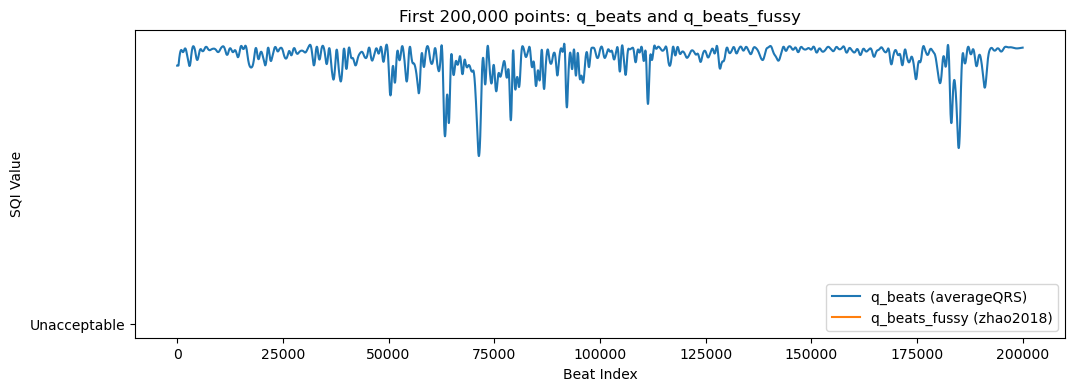

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(q_beats[:200000])
plt.title("First 2000 points in q_beats")
plt.xlabel("Beat Index")
plt.ylabel("SQI (averageQRS)")
plt.show()

In [23]:
# Virker kun på udsnit af signalet. Eks relevant i telemedicin-konteksten?
# signals, info = nk.ecg_process(sig1, sampling_rate=1000)

# nk.ecg_plot(signals, info)

In [ ]:
# print(len(labels))
# print(len(labels_pred))

# print(labels[len(labels)-1])
# print(labels_pred[len(labels_pred)-1])

# print(len(segments))

763
763
2
3
763


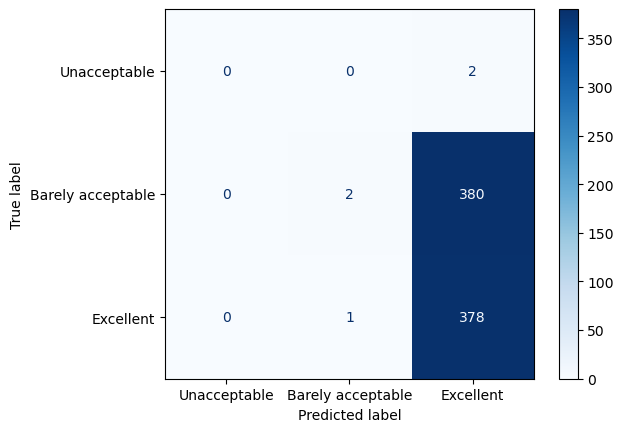

In [81]:
# Get predictions for each segment
labels_pred = []
for seg in segments:
    # Find beats within the segment
    beats_in_segment = (rpeaks_idx >= seg[0]) & (rpeaks_idx <= seg[1])
    seg_q_beats = q_beats[rpeaks_idx[beats_in_segment]]
    if len(seg_q_beats) == 0:
        # No beats in segment, handle as needed (e.g., assign lowest quality)
        labels_pred.append(3)
        continue

    seg_sqi_mean = np.mean(seg_q_beats)
    # seg_sqi_mean = np.min(seg_q_beats)
    # seg_sqi_mean = np.median(seg_q_beats)


    if seg_sqi_mean < 0.5:
        labels_pred.append(3)  # Unacceptable
    elif seg_sqi_mean < 0.8:
        labels_pred.append(2)  # Barely acceptable
    else:
        labels_pred.append(1)  # Excellent

# --- 2) Evaluer resultatet ---
# Prepare DataFrame for evaluation
df = pd.DataFrame({
    "label_true": labels.dropna().astype(int).values,
    "label_pred": labels_pred
})
df["label_true_str"] = df["label_true"].map({1: "Excellent", 2: "Barely acceptable", 3: "Unacceptable"})
df["label_pred_str"] = df["label_pred"].map({1: "Excellent", 2: "Barely acceptable", 3: "Unacceptable"})
cm = confusion_matrix(df["label_true_str"], df["label_pred_str"], labels=["Unacceptable", "Barely acceptable", "Excellent"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Unacceptable", "Barely acceptable", "Excellent"])
disp.plot(cmap="Blues")
plt.show()



In [92]:
print(labels[1])
print(labels_true_str[1])
print(labels_true_str_fussy)

1
Excellent
['Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent', 'Excellent',

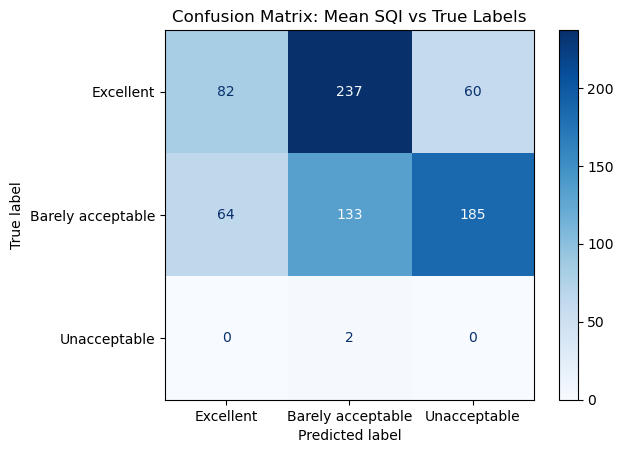

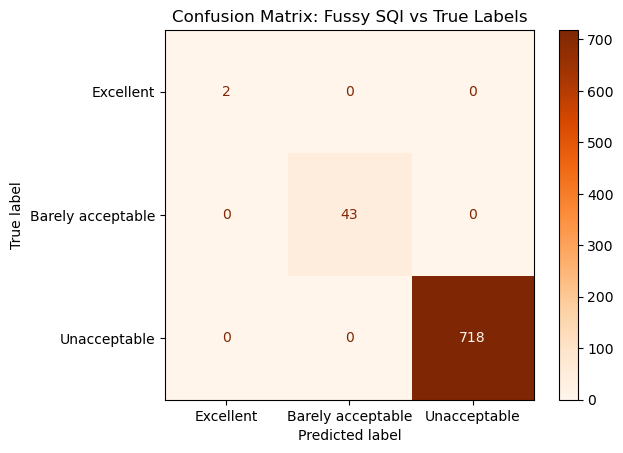

In [93]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prepare predicted labels for q_beats_test1 (mean SQI) and q_beats_fussy_test1 (fussy SQI)
def classify_sqi_numeric(sqi_mean):
    if sqi_mean < 0.5:
        return "Unacceptable"
    elif sqi_mean < 0.8:
        return "Barely acceptable"
    else:
        return "Excellent"

def map_labels_to_strings(label_val):
    if label_val == 3:
        return "Unacceptable"
    elif label_val == 2:
        return "Barely acceptable"
    elif label_val == 1:
        return "Excellent"
    else:
        return "Unknown"

# For q_beats_test1 (mean SQI per segment)
labels_pred_mean = [classify_sqi_numeric(val) for val in q_beats_test1]

# For q_beats_fussy_test1 (already string labels)
labels_pred_fussy = q_beats_fussy_test1

# True labels (as string)
labels_true_str = [map_labels_to_strings(val) for val in labels]

import matplotlib.pyplot as plt

# Confusion matrix for mean SQI
cm_mean = confusion_matrix(labels_true_str, labels_pred_mean, labels=CLASSES)
disp_mean = ConfusionMatrixDisplay(confusion_matrix=cm_mean, display_labels=CLASSES)
disp_mean.plot(cmap="Blues")
plt.title("Confusion Matrix: Mean SQI vs True Labels")
plt.show()

# Confusion matrix for fussy SQI
# labels_true_str_fussy = [classify_sqi(val) for val in labels[:len(labels_pred_fussy)]]
cm_fussy = confusion_matrix(labels_pred_fussy, labels_pred_fussy, labels=CLASSES)
disp_fussy = ConfusionMatrixDisplay(confusion_matrix=cm_fussy, display_labels=CLASSES)
disp_fussy.plot(cmap="Oranges")
plt.title("Confusion Matrix: Fussy SQI vs True Labels")
plt.show()

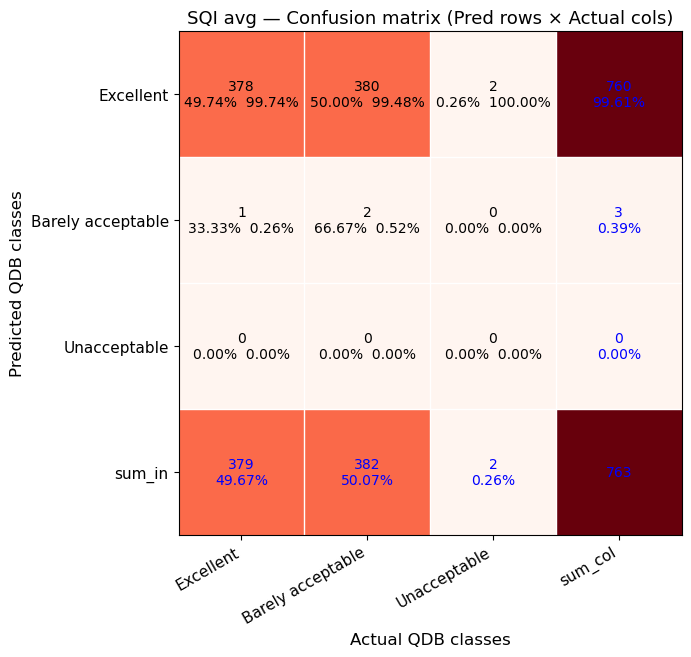

                   precision    recall  f1-score   support

        Excellent       0.50      1.00      0.66       379
Barely acceptable       0.67      0.01      0.01       382
     Unacceptable       0.00      0.00      0.00         2

         accuracy                           0.50       763
        macro avg       0.39      0.33      0.22       763
     weighted avg       0.58      0.50      0.33       763



In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# =========================
# 0) Ind: y_true, y_pred
#    Brug dine eksisterende arrays/serier her:
#    - df["label_true_str"], df["label_pred_str"] i strenge
#    ELLER map dine 1/2/3 -> strenge nedenfor.
# =========================

# >>> Skift disse to til dine egne variabler, hvis de allerede er strenge:
y_true_in = df["label_true"]  # kan være 1/2/3 eller tekst
y_pred_in = df["label_pred"]

# Kanoniser labels til samme 3 strenge
CLASSES = ["Excellent", "Barely acceptable", "Unacceptable"]

def canon_label(x):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return None
    s = str(x).strip().lower()
    m = {
        "0":"unacceptable", "1":"barely acceptable", "2":"excellent",
        "1.0":"barely acceptable", "2.0":"excellent",
        "3":"unacceptable", "3.0":"unacceptable",
        "excellent":"excellent", "barely acceptable":"barely acceptable",
        "unacceptable":"unacceptable",
        # danske synonymer (valgfrit)
        "god":"excellent", "middel":"barely acceptable", "dårlig":"unacceptable"
    }
    # Hvis dine sande labels er 1/2/3 med 1=Excellent, 2=Barely, 3=Unacceptable:
    if s in {"1","1.0"}: return "Excellent"
    if s in {"2","2.0"}: return "Barely acceptable"
    if s in {"3","3.0"}: return "Unacceptable"
    # fallback til 0/1/2 mapping
    if s in m: s = m[s]
    # titel-case tilbage
    return {"excellent":"Excellent","barely acceptable":"Barely acceptable","unacceptable":"Unacceptable"}.get(s, None)

y_true = pd.Series([canon_label(v) for v in y_true_in]).dropna()
y_pred = pd.Series([canon_label(v) for v in y_pred_in]).iloc[:len(y_true)]
y_true = y_true.iloc[:len(y_pred)]

# =========================
# 1) Confusion matrix (sklearn er True x Pred; vi transponerer til Pred x True)
# =========================
cm_tp = confusion_matrix(y_true, y_pred, labels=CLASSES)   # rows=true, cols=pred
cm = cm_tp.T                                               # rows=pred, cols=true  ✅ som i artiklen

row_sum = cm.sum(axis=1, keepdims=True)
col_sum = cm.sum(axis=0, keepdims=True)
total   = cm.sum()

# undgå division by zero
row_pct = np.divide(cm, row_sum, out=np.zeros_like(cm, dtype=float), where=row_sum!=0)  # pr. RÆKKE (precision-lign.)
col_pct = np.divide(cm, col_sum, out=np.zeros_like(cm, dtype=float), where=col_sum!=0)  # pr. KOLONNE (recall-lign.)

# =========================
# 2) Plot med rand-summer (sum_row / sum_col) og tekst i celler
# =========================
fig, ax = plt.subplots(figsize=(7,7))
# udvidet matrix 4x4 med totals
cm_aug = np.zeros((len(CLASSES)+1, len(CLASSES)+1), dtype=int)
cm_aug[:-1,:-1] = cm
cm_aug[:-1,-1]  = row_sum.ravel()     # sum_in (rækker = predicted)
cm_aug[-1,:-1]  = col_sum.ravel()     # sum_col (kolonner = actual)
cm_aug[-1,-1]   = total

im = ax.imshow(cm_aug, cmap="Reds")

# akse-etiketter (som i artiklen)
row_labels = CLASSES + ["sum_in"]
col_labels = CLASSES + ["sum_col"]
ax.set_yticks(range(len(row_labels))); ax.set_yticklabels(row_labels, fontsize=11)
ax.set_xticks(range(len(col_labels))); ax.set_xticklabels(col_labels, fontsize=11, rotation=30, ha="right")

ax.set_ylabel("Predicted QDB classes", fontsize=12)
ax.set_xlabel("Actual QDB classes", fontsize=12)
ax.set_title("SQI avg — Confusion matrix (Pred rows × Actual cols)", fontsize=13)

# tekst-annoteringer
for i in range(len(CLASSES)):
    for j in range(len(CLASSES)):
        c = cm[i, j]
        r = row_pct[i, j] * 100.0
        k = col_pct[i, j] * 100.0
        # to linjer: antal + (række%, kolonne%)
        txt = f"{c}\n{r:.2f}%  {k:.2f}%"
        ax.text(j, i, txt, va="center", ha="center", fontsize=10, color="black")

# rand-celler (summer + andele)
for i in range(len(CLASSES)):  # sidste kolonne (sum_in / pr. række)
    rcount = row_sum[i,0]
    rperc  = 100.0 * (rcount / total) if total else 0.0
    ax.text(len(CLASSES), i, f"{rcount}\n{rperc:.2f}%", va="center", ha="center", fontsize=10, color="blue")

for j in range(len(CLASSES)):  # sidste række (sum_col / pr. kolonne)
    ccount = col_sum[0,j]
    cperc  = 100.0 * (ccount / total) if total else 0.0
    ax.text(j, len(CLASSES), f"{ccount}\n{cperc:.2f}%", va="center", ha="center", fontsize=10, color="blue")

# nederste højre (total)
ax.text(len(CLASSES), len(CLASSES), f"{total}", va="center", ha="center", fontsize=10, color="blue")

# gitterlinjer for læsbarhed
ax.set_xlim(-0.5, len(CLASSES)+0.5)
ax.set_ylim(len(CLASSES)+0.5, -0.5)
ax.grid(False)
for x in range(len(CLASSES)):
    ax.axvline(x+0.5, color="white", lw=1)
    ax.axhline(x+0.5, color="white", lw=1)

plt.tight_layout()
plt.show()

# (valgfrit) Klassifikationsrapport — NB: kræver true/pred i samme orden
print(classification_report(y_true, y_pred, labels=CLASSES, zero_division=0))
